# MAGIC AI Workshop 02 Convolutional neural networks

## Introduction

In this lab, we'll look at how to use the Keras package to build a convolutional neural network (CNN). We'll use this for an image classification problem, and we'll look at the different types of layers used in a CNN, as well as code to work with large sets of images by batch processing. The code and example are modified from Shirin Elsinghorst's excellent blog on machine learning (https://shirinsplayground.netlify.com/2018/06/keras_fruits/) 

We'll use a dataset from Kaggle (https://www.kaggle.com/moltean/fruits) containing over 90,000 images of fruits and vegetables. We'll just be using a subset of these data, and you'll need to download the zip file *fruits.zip* from gtihub and move this to your working directory. 

Once you have unzipped the data, take a look in the *fruits* folder. This is already set up in the standard way for image classification. There are two high level folders `Training` and `Testing`, each of which contains a subset of the images. Not too surprisingly, the first will be used to train the model, and the second to test the model. Within each of these, there will be a set of folders, one per class of fruit. The name of the folders is used as the *label* for each image, and is what Tensorflow will use. 

- fruits
  - Training
    - Apple
    - Banana
    - ...
  - Testing
    - Apple
    - Banana
    - ...

Note that this is a specific format for image classification. There are other options, for example, if you are working with continuous outcomes. 

I'd suggest making a new virtual environment or Conda environment for this exercise:

```
conda create -name tf
conda activate tf
```


You will need to make sure you have the following Python packages installed. Please ask if you have any issues installing these:

- `numpy`
- `pandas`
- `matplotlib`
- `seaborn`
- `tensorflow`
- `PIL` 
- `scikit-learn`


## Image classification

### Data processing
Let's start, as usual, by loading the libraries we'll need for the lab:

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from PIL import Image               # to load images
from IPython.display import display # to display inline images

/var/folders/ql/nw995vq50pq3dlrxhk7mm4_40000gq/T/ipykernel_57636/1417717903.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Now set the path to the folder containing the training images you downloaded. I found that you need to set the full path rather than a relative path, but your mileage may vary. If you have any questions about setting this path, please ask. 

In [2]:
# path to image folders
path = "../datafiles/fruits/"
train_image_files_path = path + "Training"

You can visualize any of the images using the Python image library (you'll need to install this) by joining the folder path to one of the image names:

In [3]:
im_file = os.path.join(train_image_files_path, "Banana", "0_100.jpg")

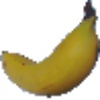

In [4]:
im = Image.open(im_file)
#show image
display(im)

You can try other images by changing the folder name and filename. Note that these are somewhat idealized images, with a blank white background. 

Next, we'll define a subset of images that we are going to process. There are 131 different types in the folder, but we'll use a subset of 16 here. This makes this a multi-class classification problem, and we'll require a different activation function to accommodate this. Feel free to choose a different set if you'd like (but it might be best to avoid folders with spaces in the names). 

In [5]:
# fruits categories
fruit_list = ["Kiwi", "Banana", "Apricot", "Avocado", "Cocos", "Clementine", "Mandarine", "Orange",
                "Limes", "Lemon", "Peach", "Plum", "Raspberry", "Strawberry", "Pineapple", "Pomegranate"]
# number of output classes (i.e. fruits)
output_n = len(fruit_list)

The original images are 100x100 pixels. Ideally we'd use these at their full resolution, but as this is an example, we'll reduce the resolution to 20x20 to make this a bit faster to run, so we set the target size here. We'll use these values (stored in `target_size` to define the input tensor shape in the network. (A good follow-up test would be to increase this and see how much it impacts the predictions.) 

In [6]:
img_width = 20
img_height = 20
target_size = (img_width, img_height)

The other dimension we need for image processing is the image depth. These are RGB images with three color channels. The input tensors then will be rank 4, with shape ($n$, 20, 20, 3), where $n$ is the number of images. 

In [7]:
channels = 3

The last parameter we'll set here is the batch size. This is the same parameter that we have used before to control the rate at which the network weights are updated. We'll also use this to control the number of images that are loaded into memory at any step. This is very useful if you're working on a computer with limited memory (like my old laptop).

In [8]:
batch_size = 32

### Image generators

Keras has several functions to facilitate working with images. We'll start by creating an image *generator*. This acts a bit like a pipeline and will carry various pre-processing steps. These include data augmentation: simple transformations of the images to supplement the original image. We're not going to use that here, but some example code is given in the appendix to illustrate how you might use this.

We'll create a generator for the training images. This will rescale each channel to a 0-1 range (the RGB channels have values between 0 and 255), and it will hold aside 30% of the training images for validation. We'll use this to check for overfitting during the training process.

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# training images
train_data_gen = ImageDataGenerator(
    rescale = 1./255,
    validation_split = 0.3
)

The next function we'll use is a *flow* function. This function controls how Keras will read in the images for any training step (i.e. any update of the network weights). There are several arguments here:

- `train_image_files_path`: The path to the top-level folder containing the training images
- `train_data_gen`: The image data generator
- `subset`: The subset of images to use from the generator for training. As we set the `validation_size` to 0.3, this will be 1 - 0.3 = 0.7, or 70% of the images
- `target_size`: The size for rescaling each image
- `class_mode`: The type of label used (this will one-hot encode the labels of the images)
- `classes`: The set of categories to use. This is the list we defined earlier and needs to match the subfolder names. If this is not included, this will use all subfolders, and create a list of labels
- `batch_size`: The number of images to import for any update step
- `seed`: a value to initialize the random number generator (this is only there to ensure consistent results)

In [10]:
# training images
train_image_array_gen = train_data_gen.flow_from_directory(train_image_files_path,                                                            
                                                           target_size = target_size,
                                                           subset = 'training',
                                                           classes = fruit_list, 
                                                           class_mode = 'categorical',
                                                           seed = 42)

Found 5401 images belonging to 16 classes.


The function will tell you how many images (and classes) it found in the folder you defined. If this is 0, go back and check the folder path you defined earlier. We'll also create a flow for the validation images. The only difference here is in the definition of the subset. 

In [11]:
# validation images
valid_image_array_gen = train_data_gen.flow_from_directory(train_image_files_path, 
                                                           target_size = target_size,
                                                           subset = 'validation',
                                                           classes = fruit_list,
                                                           class_mode = 'categorical',
                                                           seed = 42)

Found 2308 images belonging to 16 classes.


Note that these flow generators contain various useful bits of information. For example, to check the number of images (we'll also use this number when training the model):

In [12]:
train_samples = train_image_array_gen.n
valid_samples = valid_image_array_gen.n
print("Training: %d; Valid:" % train_samples, valid_samples)

Training: 5401; Valid: 2308


Or you can get the number of images per class (type of fruit)

In [13]:
pd.Series(train_image_array_gen.classes).value_counts()

2     345
9     345
10    345
13    345
15    345
1     343
4     343
5     343
6     343
8     343
12    343
14    343
7     336
0     327
11    313
3     299
Name: count, dtype: int64

Which suggest this is a relatively well-balanced dataset. This generator also contains various information about the files, resolution, channels, etc. 

### Model definition

Let's now set up the model. As this is quite a complex model, we'll do this as a series of steps rather than in one go. First, import all the modules from Keras that we'll need:

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D,
                          Dense,
                          ReLU,LeakyReLU,
                          BatchNormalization, 
                          MaxPooling2D, 
                          Dropout,
                          Flatten)
from tensorflow.keras.optimizers import RMSprop

Now, create a template sequential model:

In [15]:
model = Sequential()

Next we add the first hidden layer. This is a convolutional layer, where we'll create 16 filters (or convolutions) based on the original images, with a 3x3 kernel. We'll pad the output of this layer so that it has the same size as the input (`same`). Note that we also need to define the size of the input tensors (width, height and channels). 

In [16]:
model.add(Conv2D(filters = 16, kernel_size = (3,3), padding = 'same', 
           input_shape = (img_width, img_height, channels)))

We'll then take the output of this layer and pass it through a ReLU activation function (this could have been included directly in the convolutional layer, but this allows a little more control on the process):

In [17]:
model.add(ReLU())

Now, we add a max-pooling layer. As a reminder, this reduces the resolution of the output from the previous layer by a simple filter, forcing the next layer of the network to focus on larger image features. We'll also add a dropout layer. This is a form of regularization. It randomly sets some connection weights to 0 (i.e. having no contribution to the model), which can reduce overfitting.

In [18]:
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(.25))

Let's add another convolutional layer, this time with 32 filters, and pass this through a different activation function (a leaky ReLU)

In [19]:
model.add(Conv2D(filters = 32, kernel_size = (3,3), padding = 'same', 
           input_shape = (img_width, img_height, channels)))
model.add(LeakyReLU(0.5))

We'll take the output of this function and normalize the weights. This is a simple method that adjusts the mean weight to close to zero and reduces the amount variation. This helps avoid gradient problems with very small or very large weights

In [20]:
model.add(BatchNormalization())

And we'll run the output of this through a max-pooling function with dropout:

In [21]:
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(.25))

Now we'll add layers to connect the output of this last max-pooling step to the output (the fruit classes). The first thing we need to do is to flatten the output. The output of the max-pooling is a tensor of shape (5, 5, 32). The size of 5 is a result of the two max-pooling operations and the 32 is the number of filters from the second convolution. The `Flatten()` function will flatten this into a rank 1 tensor of shape (800). 

In [22]:
model.add(Flatten())

Next we'll pass this flattened layer through a dense layer, with a ReLU activation and a dropout

In [23]:
model.add(Dense(units = 100))
model.add(ReLU())
model.add(Dropout(.5))

Finally, we need to output predictions. As this is a multiclass task, the final layer needs to have the same number of nodes as classes (16). This is passed through a softmax activation function. This transforms the predictions for all classes into probabilities (i.e. they have to sum to 1). 

In [24]:
model.add(Dense(units = output_n, activation = 'softmax'))

Let's take a look at the whole thing:

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 20, 20, 16)        448       
                                                                 
 re_lu (ReLU)                (None, 20, 20, 16)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 10, 10, 16)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 10, 10, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 32)        4640      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 10, 10, 32)        0         
                                                        

Our model has a little under 87,000 parameters or weights to train (hence the need for a lot of images). Note that there are small set of non-trainable parameter from the normalization layer. If you'd rather build the model in one go, here's the code for that:

In [26]:
model = Sequential([   
    Conv2D(filters = 16, kernel_size = (3,3), padding = 'same', 
           input_shape = (img_width, img_height, channels), activation = 'relu'),
    ReLU(),
    MaxPooling2D(pool_size = (2,2)),
    Conv2D(filters = 32, kernel_size = (3,3), padding = 'same'),
    LeakyReLU(.5),
    BatchNormalization(),
    MaxPooling2D(pool_size = (2,2)),
    Dropout(.25),
    Flatten(),
    Dense(units = 100),
    ReLU(),
    Dropout(.5),
    Dense(units = output_n, activation = 'softmax')
])

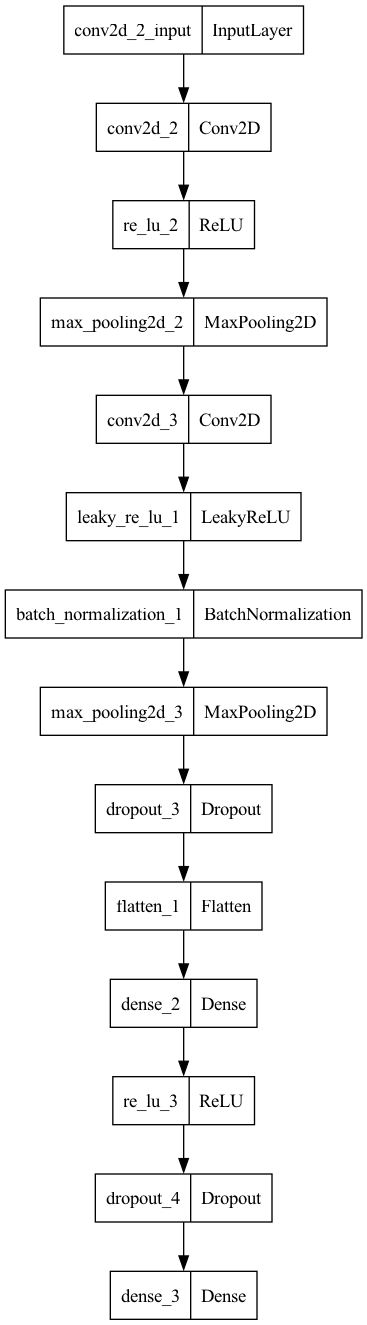

In [27]:
from tensorflow.keras.utils import plot_model
plot_model(model)

Now let's define an optimization function, loss function and performance metric. A good option for the loss function is `categorical_crossentropy`, which tries to maximize the difference between the distribution of multiple categories. We'll use a backpropagation optimizer, but change the default option for the learning rate (`lr`) to a lower value. This will limit the update to the weights as the model trains, which results in a slower training but a reduced risk of overfitting. The `decay` parameter acts to reduce the learning rate even further at each iteration of the model. 

In [29]:
model.compile(loss = 'categorical_crossentropy', 
              metrics = ['accuracy'], 
              optimizer = RMSprop(learning_rate = 1e-4))

### Training the model

We'll now train the model for 20 epochs. As we are using a data generator function to supply the images and data to the model, we use the `fit_generator()` method instead of the `fit()` function we have previously used. We specify:

- `train_image_array_gen`: The generator of the training samples
- `steps_per_epoch`: The number of update steps in each epoch (usually just number of samples / batch size)
- `epochs`: number of full training iterations
- `validation_data`: the generator of the validation samples
- `validation_steps`: the number of validation steps per epoch

This takes a few minutes to train (on my laptop). It's worth remembering what is going on here: the algorithm is reading in batches of 32 images, rescaling them, updating model weights through back propagation and then repeating the whole thing 20 times. 

In [30]:
epochs = 20
hist = model.fit_generator(
  # training data
  train_image_array_gen,

  # epochs
  steps_per_epoch = train_samples // batch_size, 
  epochs = epochs, 

  # validation data
  validation_data = valid_image_array_gen,
  validation_steps = valid_samples // batch_size,

  # print progress
  verbose = 1
)

Epoch 1/20


/var/folders/ql/nw995vq50pq3dlrxhk7mm4_40000gq/T/ipykernel_57636/4244568333.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(


168/168 [==============================] - 4s 20ms/step - loss: 2.6296 - accuracy: 0.2142 - val_loss: 2.4218 - val_accuracy: 0.3077
Epoch 2/20
168/168 [==============================] - 2s 11ms/step - loss: 1.7363 - accuracy: 0.4349 - val_loss: 1.5895 - val_accuracy: 0.7196
Epoch 3/20
168/168 [==============================] - 2s 12ms/step - loss: 1.2725 - accuracy: 0.5819 - val_loss: 0.8159 - val_accuracy: 0.8394
Epoch 4/20
168/168 [==============================] - 2s 10ms/step - loss: 0.9591 - accuracy: 0.6802 - val_loss: 0.4439 - val_accuracy: 0.9115
Epoch 5/20
168/168 [==============================] - 2s 9ms/step - loss: 0.7189 - accuracy: 0.7653 - val_loss: 0.2947 - val_accuracy: 0.9345
Epoch 6/20
168/168 [==============================] - 2s 10ms/step - loss: 0.5713 - accuracy: 0.8041 - val_loss: 0.2145 - val_accuracy: 0.9462
Epoch 7/20
168/168 [==============================] - 2s 12ms/step - loss: 0.4478 - accuracy: 0.8583 - val_loss: 0.1913 - val_accuracy: 0.9653
Epoch 8/20


Now plot the evolution of the loss function and performance metric:

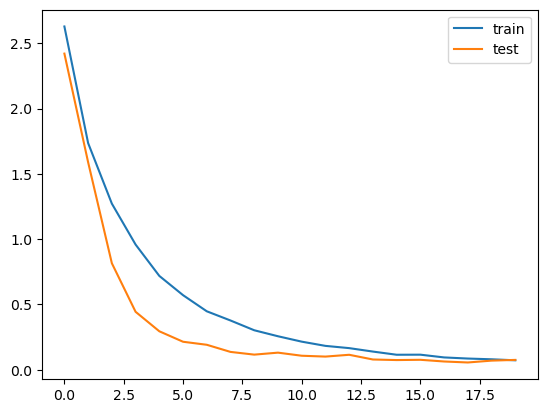

In [31]:
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='test')
plt.legend()
plt.show()

The plot shows a good evolution of both the loss and performance metrics. 

### Model evaluation

We'll now evaluate this model on the set of test images. Normally, we'd retrain the model using the full training set (including the validation set), but to save time, we'll just proceed with the existing model. In order to do this, we first need to create a new image generator for the test images:

In [32]:
test_image_files_path = path + "Test"
# test images
test_data_gen = ImageDataGenerator(
    rescale = 1./255
)
test_image_array_gen = test_data_gen.flow_from_directory(test_image_files_path, 
                                                         target_size = target_size,
                                                         classes = fruit_list,
                                                         class_mode = 'categorical',
                                                         shuffle = False,
                                                         seed = 42)

Found 2592 images belonging to 16 classes.


The only differences here from the previous code is that we use the test image folder, and we no longer specify a validation parameter. Now we can use this to evaluate the model:

In [33]:
test_loss, test_acc = model.evaluate(test_image_array_gen)

81/81 [==============================] - 1s 9ms/step - loss: 0.0531 - accuracy: 0.9823


In [34]:
print('Cross-entropy loss: %.4f'
      % test_loss)
print('Accuracy: %.4f'
      % test_acc)

Cross-entropy loss: 0.0531
Accuracy: 0.9823


Which gives us an accuracy of close to 1, which is a very good classifier. It is worth noting that this is partly because the images have all been cleaned and prepared; achieving this level of accuracy with images take 'in the wild' would require much more work in setting up and training the model.

### Predicting classes

We'll finish by obtaining predictions for the set of test images, and building a confusion matrix based on these. Predictions for new samples can be obtained using the `predict()` function. Note that if you were predicting for completely new images, you would need to make a new generator for these. 

In [35]:
test_pred = model.predict(test_image_array_gen)
test_pred.shape

81/81 [==============================] - 1s 6ms/step


(2592, 16)

For each image, there is the predicted probability of each class:

In [36]:
test_pred[0,]

array([9.9543083e-01, 2.6644786e-05, 8.0226351e-07, 6.0514103e-05,
       2.4376162e-03, 2.8399251e-07, 9.5444950e-05, 3.6210147e-06,
       3.7517162e-05, 1.8312641e-03, 4.9356455e-05, 4.8989055e-08,
       1.0472863e-06, 1.3235682e-06, 2.3526189e-05, 2.0744548e-07],
      dtype=float32)

To get the predicted labels, we simply need to find the column with the highest probability. We can use Numpy's `argmax()` function for this:

In [37]:
test_pred = np.argmax(test_pred, axis=1)

The test generator stores the observed labels for the test set, so let's extract that and store it as `obs_class`:

In [38]:
test_obs = test_image_array_gen.classes

We can now make a confusion matrix between the observed and predicted classes:

In [40]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test_obs, test_pred)

array([[156,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [  0, 166,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [  0,   0, 164,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [  0,   0,   0, 143,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [  0,   0,   0,   0, 158,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   8,   0],
       [  0,   0,   0,   0,   0, 166,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [  0,   0,   0,   0,   0,   0, 166,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0, 160,   0,   0,   0,   0,   0,
          0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0, 166,   0,   0,   0,   0,
          0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0, 164,   0,   0,   0,
          0,   0,   0],
       [  0,   0,  14,   0,   

Note that the row and column indices are integer values due to the numeric representaiton of the classes in the model. We can simply replace these with the fruit labels and make a DataFrame:

In [41]:
cm = confusion_matrix(test_obs, test_pred)

df_cm = pd.DataFrame(cm, index = [i for i in fruit_list],
                  columns = [i for i in fruit_list])
df_cm

,Kiwi,Banana,Apricot,Avocado,Cocos,Clementine,Mandarine,Orange,Limes,Lemon,Peach,Plum,Raspberry,Strawberry,Pineapple,Pomegranate
Kiwi,156,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Banana,0,166,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Apricot,0,0,164,0,0,0,0,0,0,0,0,0,0,0,0,0
Avocado,0,0,0,143,0,0,0,0,0,0,0,0,0,0,0,0
Cocos,0,0,0,0,158,0,0,0,0,0,0,0,0,0,8,0
Clementine,0,0,0,0,0,166,0,0,0,0,0,0,0,0,0,0
Mandarine,0,0,0,0,0,0,166,0,0,0,0,0,0,0,0,0
Orange,0,0,0,0,0,0,0,160,0,0,0,0,0,0,0,0
Limes,0,0,0,0,0,0,0,0,166,0,0,0,0,0,0,0
Lemon,0,0,0,0,0,0,0,0,0,164,0,0,0,0,0,0


This shows why we got such a high accuracy - nearly all the images are correctly classified. Let's finish by plotting this result using Seaborn's `heatmap()` function:

<Axes: >

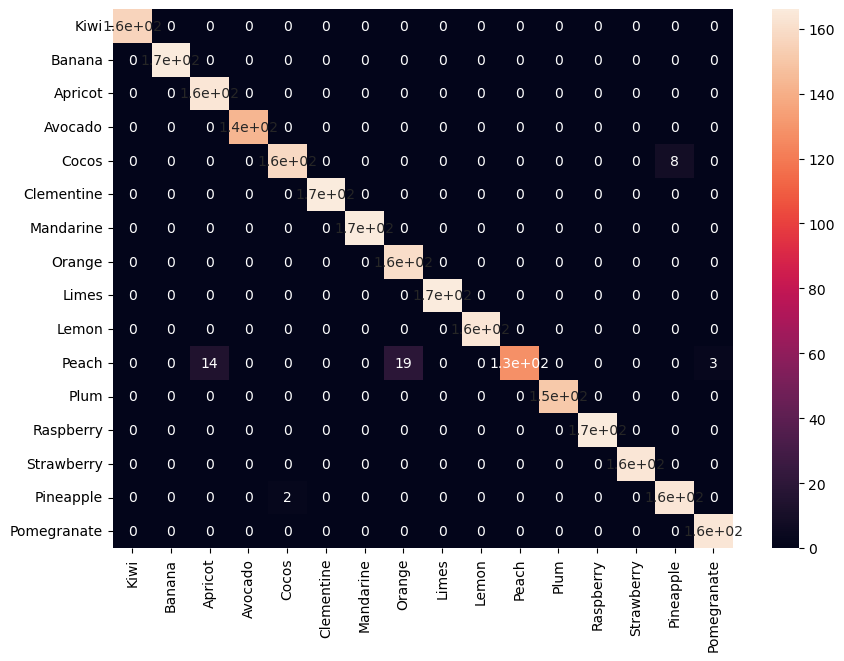

In [42]:
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

The default confusion matrix shows the number of correctly/incorrectly classified images. You can also generate the proportion of correct/incorrect predictions by normalizing the confusion matrix:

<Axes: >

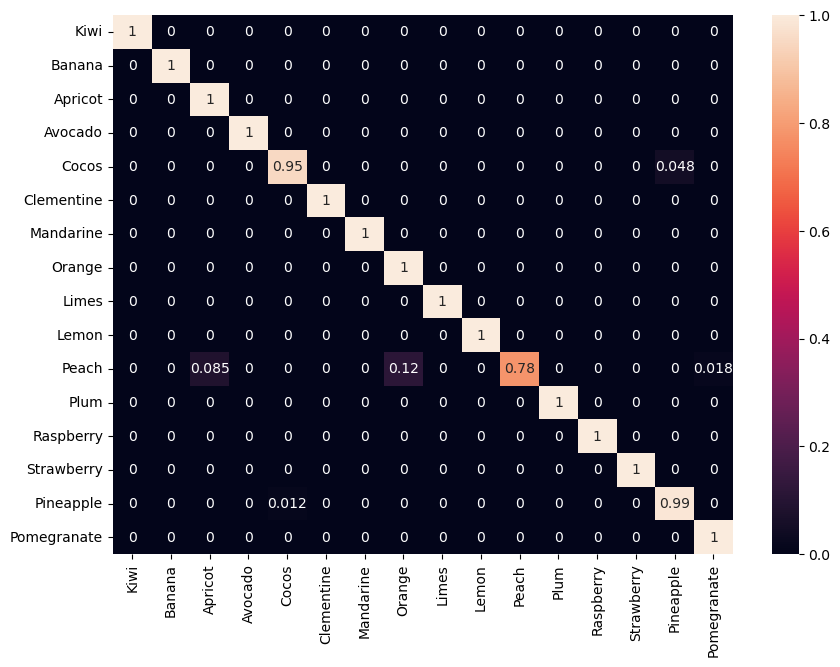

In [43]:
cm = confusion_matrix(test_obs, test_pred, normalize='true')

df_cm = pd.DataFrame(cm, index = [i for i in fruit_list],
                  columns = [i for i in fruit_list])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

## Appendix

This is an example of an image generator that will perform data augmentation. In each epoch, each image is transformed according to a set of random modifications. The parameters here set limits on the amount of transformation that any method will carry out. For example, images will be randomly rotated by an amount between + and - 40 degrees.

In [ ]:
train_data_gen = ImageDataGenerator(
    rescale = 1./255, ## Rescale channel values
    rotation_range=40, ## Random rotation (+/- 40 degrees)
    width_shift_range=0.2, ## Random horizontal shift (+/- proportion of image size)
    height_shift_range=0.2, ## Random vertical shift (+/- proportion of image size)
    shear_range=0.2, ## Shear angle in counter-clockwise direction in degrees
    zoom_range=0.2, ## Zoom range. Zooms by 1 +/- 0.2 from original
    horizontal_flip=True, ## Randomly flips 50% of images
    fill_mode='nearest', ## How to fill newly created pixels (nearest neighbor)
)